In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Download dataset
print("Downloading dataset...")
path = kagglehub.dataset_download("shubhamgupta012/crime-data-from-2020-to-present")
print(f"Path to dataset files: {path}")


100%|██████████| 36.5M/36.5M [00:00<00:00, 114MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shubhamgupta012/crime-data-from-2020-to-present/versions/1


In [ ]:
# Load the dataset
import os
files = os.listdir(path)
print(f"\nFiles in dataset: {files}")

csv_file = [f for f in files if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, csv_file))

print(f"\nDataset shape: {df.shape}")
print("\n" + "="*80)
print("INITIAL DATA EXPLORATION")
print("="*80)
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nBasic statistics:\n{df.describe()}")


Files in dataset: ['Crime_Data_from_2020_to_Present.csv']

Dataset shape: (743817, 28)

INITIAL DATA EXPLORATION

First few rows:
       DR_NO               Date Rptd                DATE OCC  TIME OCC  AREA  \
0   10304468  01/08/2020 12:00:00 AM  01/08/2020 12:00:00 AM      2230     3   
1  190101086  01/02/2020 12:00:00 AM  01/01/2020 12:00:00 AM       330     1   
2  200110444  04/14/2020 12:00:00 AM  02/13/2020 12:00:00 AM      1200     1   
3  191501505  01/01/2020 12:00:00 AM  01/01/2020 12:00:00 AM      1730    15   
4  191921269  01/01/2020 12:00:00 AM  01/01/2020 12:00:00 AM       415    19   

     AREA NAME  Rpt Dist No  Part 1-2  Crm Cd  \
0    Southwest          377         2     624   
1      Central          163         2     624   
2      Central          155         2     845   
3  N Hollywood         1543         2     745   
4      Mission         1998         2     740   

                                         Crm Cd Desc  ... Status  \
0                        

In [ ]:
print("\n" + "="*80)
print("DATA CLEANING")
print("="*80)

# Create a copy for cleaning
df_clean = df.copy()

# Remove duplicate rows
initial_rows = len(df_clean)
df_clean = df_clean.drop_duplicates()
print(f"\nRemoved {initial_rows - len(df_clean)} duplicate rows")

# Handle missing values
print(f"\nMissing values before cleaning:\n{df_clean.isnull().sum()[df_clean.isnull().sum() > 0]}")

# Drop columns with too many missing values (>50%)
threshold = len(df_clean) * 0.5
df_clean = df_clean.dropna(thresh=threshold, axis=1)


DATA CLEANING

Removed 0 duplicate rows

Missing values before cleaning:
Mocodes           102024
Vict Sex           97040
Vict Descent       97046
Premis Cd              9
Premis Desc          424
Weapon Used Cd    485624
Weapon Desc       485624
Crm Cd 1               9
Crm Cd 2          688731
Crm Cd 3          741978
Crm Cd 4          743763
Cross Street      624067
dtype: int64


In [ ]:
# For remaining columns, handle missing values
for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        if df_clean[col].dtype in ['int64', 'float64']:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
        else:
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

print(f"\nMissing values after cleaning:\n{df_clean.isnull().sum().sum()} total missing values")

# Convert date columns if present
date_columns = [col for col in df_clean.columns if 'date' in col.lower() or 'time' in col.lower()]
for col in date_columns:
    try:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
        print(f"\nConverted {col} to datetime")
    except:
        pass


Missing values after cleaning:
0 total missing values

Converted Date Rptd to datetime

Converted DATE OCC to datetime

Converted TIME OCC to datetime


In [ ]:
# Remove outliers using IQR method for numeric columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
print(f"\nRemoving outliers from numeric columns...")
for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    initial_count = len(df_clean)
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    removed = initial_count - len(df_clean)
    if removed > 0:
        print(f"  {col}: removed {removed} outliers")

print(f"\nCleaned dataset shape: {df_clean.shape}")



Removing outliers from numeric columns...
  DR_NO: removed 4 outliers
  Vict Age: removed 391 outliers
  LAT: removed 23389 outliers

Cleaned dataset shape: (720033, 22)


In [ ]:
# FEATURE ENGINEERING FOR ANN
# ============================================================================
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Select relevant columns for modeling
# We'll try to predict crime type or status based on available features
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nCategorical columns: {len(categorical_cols)}")
print(f"Numeric columns: {len(numeric_cols)}")

# Select target variable (most common: crime type or status)
# Let's identify the best target column
potential_targets = ['Crm Cd Desc', 'Status Desc', 'Crime Code Description', 'Status']
target_col = None
for col in potential_targets:
    if col in df_clean.columns:
        target_col = col
        break

if target_col is None:
    # Use the first categorical column with reasonable number of classes
    for col in categorical_cols:
        n_unique = df_clean[col].nunique()
        if 2 <= n_unique <= 50:
            target_col = col
            break

print(f"\nTarget variable: {target_col}")
print(f"Target classes: {df_clean[target_col].nunique()}")
print(f"\nTop 10 target values:\n{df_clean[target_col].value_counts().head(10)}")

# Limit to top N classes for better training
TOP_N_CLASSES = 10
top_classes = df_clean[target_col].value_counts().head(TOP_N_CLASSES).index
df_model = df_clean[df_clean[target_col].isin(top_classes)].copy()

print(f"\nFiltered to top {TOP_N_CLASSES} classes. New shape: {df_model.shape}")

# Prepare features
feature_cols = [col for col in df_model.columns if col != target_col]

# Encode categorical features
le_dict = {}
X_encoded = df_model[feature_cols].copy()

for col in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    le_dict[col] = le


FEATURE ENGINEERING

Categorical columns: 9
Numeric columns: 10

Target variable: Crm Cd Desc
Target classes: 138

Top 10 target values:
Crm Cd Desc
VEHICLE - STOLEN                                           76600
BATTERY - SIMPLE ASSAULT                                   56745
THEFT OF IDENTITY                                          47044
BURGLARY FROM VEHICLE                                      45079
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    44114
BURGLARY                                                   44037
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT             41279
THEFT PLAIN - PETTY ($950 & UNDER)                         37047
INTIMATE PARTNER - SIMPLE ASSAULT                          35822
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)            28128
Name: count, dtype: int64

Filtered to top 10 classes. New shape: (455895, 22)


In [ ]:
# Handle datetime columns
for col in X_encoded.columns:
    if pd.api.types.is_datetime64_any_dtype(X_encoded[col]):
        X_encoded[f'{col}_year'] = X_encoded[col].dt.year
        X_encoded[f'{col}_month'] = X_encoded[col].dt.month
        X_encoded[f'{col}_day'] = X_encoded[col].dt.day
        X_encoded[f'{col}_hour'] = X_encoded[col].dt.hour
        X_encoded = X_encoded.drop(col, axis=1)

# Encode target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(df_model[target_col])

print(f"\nFeature matrix shape: {X_encoded.shape}")
print(f"Target shape: {y_encoded.shape}")


Feature matrix shape: (455895, 30)
Target shape: (455895,)


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set size: {X_train_scaled.shape}")
print(f"Test set size: {X_test_scaled.shape}")



Training set size: (364716, 30)
Test set size: (91179, 30)


In [ ]:
print("\n" + "="*80)
print("BUILDING ARTIFICIAL NEURAL NETWORK")
print("="*80)

# Build ANN model
n_features = X_train_scaled.shape[1]
n_classes = len(np.unique(y_encoded))

model = keras.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())




BUILDING ARTIFICIAL NEURAL NETWORK


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,634 (57.16 KB)

 Trainable params: 14,634 (57.16 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Train the model
print("\nTraining the model...")
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)




Training the model...
Epoch 1/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7658 - loss: 0.6122 - val_accuracy: 0.9587 - val_loss: 0.0930
Epoch 2/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9509 - loss: 0.1161 - val_accuracy: 0.9639 - val_loss: 0.0813
Epoch 3/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9601 - loss: 0.0929 - val_accuracy: 0.9672 - val_loss: 0.0747
Epoch 4/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9631 - loss: 0.0863 - val_accuracy: 0.9689 - val_loss: 0.0719
Epoch 5/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9649 - loss: 0.0827 - val_accuracy: 0.9705 - val_loss: 0.0694
Epoch 6/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9660 - loss: 0.0798 - val_accuracy: 0.9724 - val_loss: 0.0652
Epoch 7/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9672 - loss: 0.0766 - val_accuracy: 0.9693 - val_loss: 0.0670
Epoch 8/50
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0

In [ ]:
# ============================================================================
# EVALUATE MODEL
# ============================================================================
print("\n" + "="*80)
print("MODEL EVALUATION")
print("="*80)

# Predictions
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Metrics
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"\nTest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes,
                          target_names=le_target.classes_[:n_classes]))





MODEL EVALUATION
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 2s 678us/step

Test Accuracy: 0.9993

Classification Report:
                                                         precision    recall  f1-score   support

         ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       1.00      1.00      1.00      8256
                               BATTERY - SIMPLE ASSAULT       1.00      1.00      1.00     11349
                                               BURGLARY       1.00      1.00      1.00      8807
                                  BURGLARY FROM VEHICLE       1.00      1.00      1.00      9016
                      INTIMATE PARTNER - SIMPLE ASSAULT       1.00      0.99      1.00      7164
        THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)       1.00      1.00      1.00      5626
                                      THEFT OF IDENTITY       1.00      1.00      1.00      9409
                     THEFT PLAIN - PETTY ($950 & UNDER)       1.00      1.00      1.00      7409
VANDALISM - FELO


Generating visualizations...


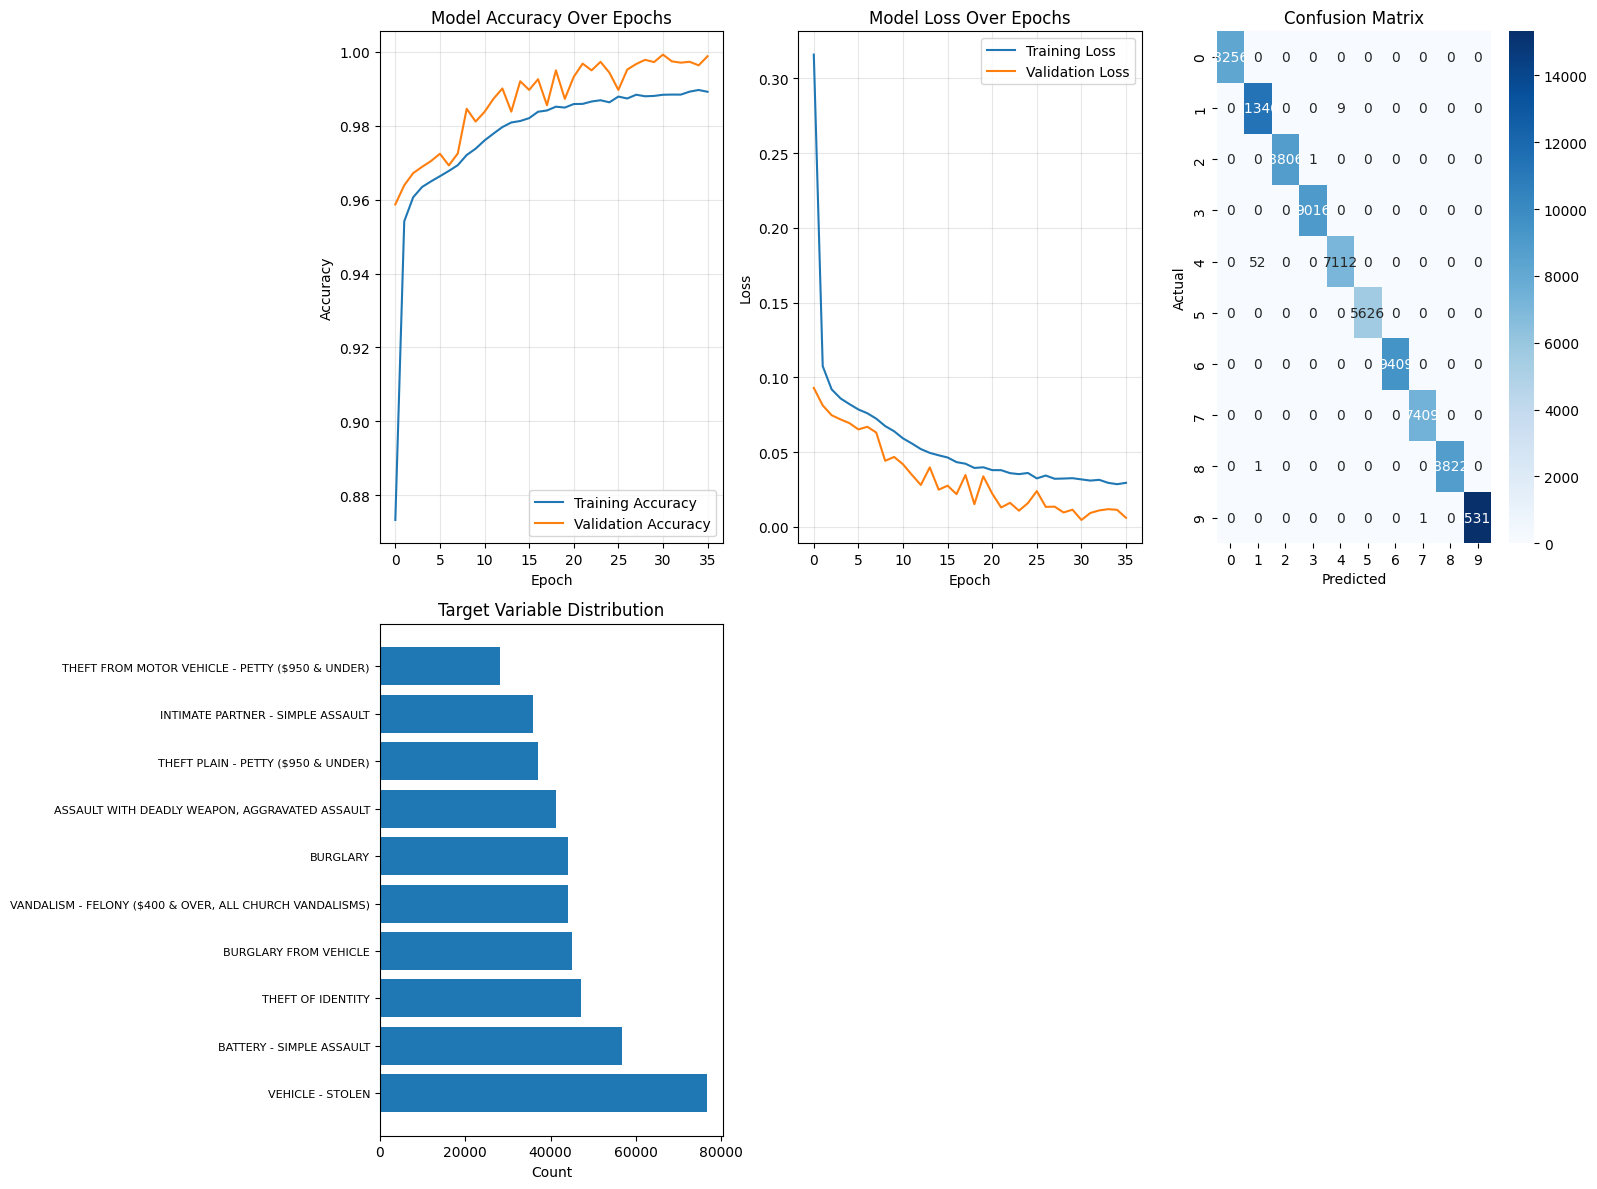

In [ ]:

# VISUALIZATIONS
# ============================================================================
print("\nGenerating visualizations...")

fig = plt.figure(figsize=(16, 12))

# 1. Training history
ax1 = plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Loss history
ax2 = plt.subplot(2, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Confusion Matrix
ax3 = plt.subplot(2, 3, 3)
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 4. Target distribution
ax4 = plt.subplot(2, 3, 4)
target_counts = df_model[target_col].value_counts()
plt.barh(range(len(target_counts)), target_counts.values)
plt.yticks(range(len(target_counts)), target_counts.index, fontsize=8)
plt.xlabel('Count')
plt.title('Target Variable Distribution')
plt.tight_layout()


Visualization saved as 'crime_ann_analysis_results.png'


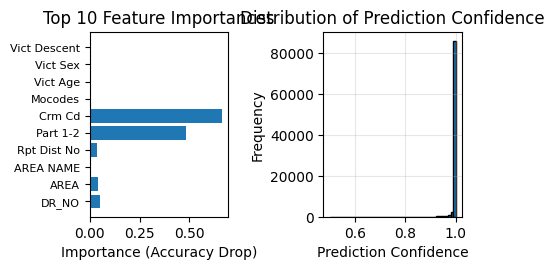


SAVING RESULTS

Model saved as 'crime_prediction_ann_model.h5'
Cleaned dataset saved as 'cleaned_crime_data.csv'
Results summary saved as 'model_results_summary.txt'

ANALYSIS COMPLETE!

Final Model Accuracy: 99.93%
Model trained on 364716 samples
Model tested on 91179 samples

Files generated:
  - crime_prediction_ann_model.h5
  - cleaned_crime_data.csv
  - crime_ann_analysis_results.png
  - model_results_summary.txt


In [ ]:
# 5. Feature importance (using permutation importance approximation)
ax5 = plt.subplot(2, 3, 5)
baseline_accuracy = accuracy
importances = []
for i in range(min(10, X_test_scaled.shape[1])):
    X_test_permuted = X_test_scaled.copy()
    np.random.shuffle(X_test_permuted[:, i])
    y_pred_permuted = model.predict(X_test_permuted, verbose=0)
    y_pred_classes_permuted = np.argmax(y_pred_permuted, axis=1)
    permuted_accuracy = accuracy_score(y_test, y_pred_classes_permuted)
    importance = baseline_accuracy - permuted_accuracy
    importances.append(importance)

feature_names = X_encoded.columns[:10]
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), feature_names, fontsize=8)
plt.xlabel('Importance (Accuracy Drop)')
plt.title('Top 10 Feature Importances')

# 6. Prediction confidence distribution
ax6 = plt.subplot(2, 3, 6)
max_probs = np.max(y_pred, axis=1)
plt.hist(max_probs, bins=50, edgecolor='black')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Confidence')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('crime_ann_analysis_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'crime_ann_analysis_results.png'")
plt.show()

# ============================================================================
# SAVE MODEL AND RESULTS
# ============================================================================
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

model.save('crime_prediction_ann_model.h5')
print("\nModel saved as 'crime_prediction_ann_model.h5'")

# Save cleaned dataset
df_clean.to_csv('cleaned_crime_data.csv', index=False)
print("Cleaned dataset saved as 'cleaned_crime_data.csv'")

# Save results summary
results_summary = {
    'Model': 'Artificial Neural Network',
    'Test Accuracy': accuracy,
    'Number of Classes': n_classes,
    'Number of Features': n_features,
    'Training Samples': len(X_train),
    'Test Samples': len(X_test),
    'Target Variable': target_col
}

with open('model_results_summary.txt', 'w') as f:
    f.write("Crime Data Analysis - ANN Model Results\n")
    f.write("="*50 + "\n\n")
    for key, value in results_summary.items():
        f.write(f"{key}: {value}\n")
    f.write("\n" + "="*50 + "\n")
    f.write("Classification Report:\n\n")
    f.write(classification_report(y_test, y_pred_classes,
                                 target_names=le_target.classes_[:n_classes]))

print("Results summary saved as 'model_results_summary.txt'")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print(f"\nFinal Model Accuracy: {accuracy:.2%}")
print(f"Model trained on {len(X_train)} samples")
print(f"Model tested on {len(X_test)} samples")
print(f"\nFiles generated:")
print("  - crime_prediction_ann_model.h5")
print("  - cleaned_crime_data.csv")
print("  - crime_ann_analysis_results.png")
print("  - model_results_summary.txt")

## **LSTM**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

In [ ]:
print("\nCleaning data...")
df_clean = df.copy()

# Remove duplicates
df_clean = df_clean.drop_duplicates()

# Drop columns with >50% missing values
threshold = len(df_clean) * 0.5
df_clean = df_clean.dropna(thresh=threshold, axis=1)

# Fill remaining missing values
for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        if df_clean[col].dtype in ['int64', 'float64']:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
        else:
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Convert date columns
date_columns = [col for col in df_clean.columns if 'date' in col.lower() or 'time' in col.lower()]
for col in date_columns:
    try:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
    except:
        pass

print(f"Cleaned dataset shape: {df_clean.shape}")


Cleaning data...
Cleaned dataset shape: (743817, 22)


In [ ]:
print("\n" + "="*80)
print("TIME-SERIES FEATURE ENGINEERING")
print("="*80)

# Find datetime column
datetime_col = None
for col in df_clean.columns:
    if pd.api.types.is_datetime64_any_dtype(df_clean[col]):
        datetime_col = col
        break

if datetime_col:
    print(f"\nUsing datetime column: {datetime_col}")
    df_clean = df_clean.sort_values(datetime_col)
    df_clean = df_clean.reset_index(drop=True)

    # Extract temporal features
    df_clean['year'] = df_clean[datetime_col].dt.year
    df_clean['month'] = df_clean[datetime_col].dt.month
    df_clean['day'] = df_clean[datetime_col].dt.day
    df_clean['hour'] = df_clean[datetime_col].dt.hour
    df_clean['dayofweek'] = df_clean[datetime_col].dt.dayofweek
    df_clean['quarter'] = df_clean[datetime_col].dt.quarter
    df_clean['is_weekend'] = (df_clean['dayofweek'] >= 5).astype(int)
else:
    print("\nNo datetime column found, creating synthetic time index")
    df_clean['time_index'] = range(len(df_clean))

# Select target variable
potential_targets = ['Crm Cd Desc', 'Status Desc', 'Crime Code Description', 'Status']
target_col = None
for col in potential_targets:
    if col in df_clean.columns:
        target_col = col
        break

if target_col is None:
    categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
    for col in categorical_cols:
        n_unique = df_clean[col].nunique()
        if 2 <= n_unique <= 50:
            target_col = col
            break

print(f"\nTarget variable: {target_col}")
print(f"Number of unique classes: {df_clean[target_col].nunique()}")

# Use top classes for better performance
TOP_N_CLASSES = 10
top_classes = df_clean[target_col].value_counts().head(TOP_N_CLASSES).index
df_model = df_clean[df_clean[target_col].isin(top_classes)].copy()
df_model = df_model.reset_index(drop=True)

print(f"Filtered to top {TOP_N_CLASSES} classes: {df_model.shape}")
print(f"\nClass distribution:\n{df_model[target_col].value_counts()}")


TIME-SERIES FEATURE ENGINEERING

Using datetime column: Date Rptd

Target variable: Crm Cd Desc
Number of unique classes: 138
Filtered to top 10 classes: (470580, 29)

Class distribution:
Crm Cd Desc
VEHICLE - STOLEN                                           79513
BATTERY - SIMPLE ASSAULT                                   58896
THEFT OF IDENTITY                                          48155
BURGLARY FROM VEHICLE                                      46016
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    45626
BURGLARY                                                   45164
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT             42616
THEFT PLAIN - PETTY ($950 & UNDER)                         38065
INTIMATE PARTNER - SIMPLE ASSAULT                          37508
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)            29021
Name: count, dtype: int64


In [ ]:
print("\n" + "="*80)
print("CREATING TIME-SERIES SEQUENCES")
print("="*80)

# Prepare features
feature_cols = [col for col in df_model.columns if col != target_col]

# Encode categorical features
X_encoded = df_model[feature_cols].copy()
le_dict = {}

for col in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    le_dict[col] = le

# Handle remaining datetime columns
for col in X_encoded.columns:
    if pd.api.types.is_datetime64_any_dtype(X_encoded[col]):
        X_encoded = X_encoded.drop(col, axis=1)

# Encode target
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(df_model[target_col])

# Scale features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Create sequences for LSTM
# LSTM needs input shape: (samples, timesteps, features)
SEQUENCE_LENGTH = 10  # Use last 10 records to predict next one

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_sequences, y_sequences = create_sequences(X_scaled, y_encoded, SEQUENCE_LENGTH)

print(f"\nSequence shape: {X_sequences.shape}")
print(f"  - Samples: {X_sequences.shape[0]}")
print(f"  - Timesteps: {X_sequences.shape[1]}")
print(f"  - Features: {X_sequences.shape[2]}")


CREATING TIME-SERIES SEQUENCES

Sequence shape: (470570, 10, 25)
  - Samples: 470570
  - Timesteps: 10
  - Features: 25


In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42
)

# Convert to categorical for multi-class classification
n_classes = len(np.unique(y_encoded))
y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_test_cat = to_categorical(y_test, num_classes=n_classes)

print(f"\nTraining sequences: {X_train.shape}")
print(f"Test sequences: {X_test.shape}")


Training sequences: (376456, 10, 25)
Test sequences: (94114, 10, 25)


In [ ]:
# BUILD LSTM MODEL
# ============================================================================
print("\n" + "="*80)
print("BUILDING LSTM MODEL")
print("="*80)

model = keras.Sequential([
    layers.LSTM(128, return_sequences=True, input_shape=(SEQUENCE_LENGTH, X_sequences.shape[2])),
    layers.Dropout(0.3),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32, return_sequences=False),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())



BUILDING LSTM MODEL


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │        78,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,434 (560.29 KB)

 Trainable params: 143,434 (560.29 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# TRAIN LSTM MODEL
# ============================================================================
print("\n" + "="*80)
print("TRAINING LSTM MODEL")
print("="*80)

history = model.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
    ]
)


TRAINING LSTM MODEL
Epoch 1/50
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 124s 26ms/step - accuracy: 0.1755 - loss: 2.2550 - val_accuracy: 0.1810 - val_loss: 2.2480 - learning_rate: 0.0010
Epoch 2/50
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 117s 25ms/step - accuracy: 0.1825 - loss: 2.2452 - val_accuracy: 0.1806 - val_loss: 2.2452 - learning_rate: 0.0010
Epoch 3/50
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 144s 25ms/step - accuracy: 0.1824 - loss: 2.2445 - val_accuracy: 0.1816 - val_loss: 2.2443 - learning_rate: 0.0010
Epoch 4/50
4706/4706 ━━━━━━━━━━━━━━━━━━━━ 142s 25ms/step - accuracy: 0.1841 - loss: 2.2436 - val_accuracy: 0.1802 - val_loss: 2.2456 - learning_rate: 0.0010
Epoch 5/50
4704/4706 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1833 - loss: 2.2437